In [ ]:
# ===============================
# 1. Install Dependencies
# ===============================
!pip install -U sentence-transformers datasets

# ===============================
# 2. Mount Google Drive
# ===============================
from google.colab import drive
drive.mount('/content/drive')

# ===============================
# 3. Upload Your Files
# ===============================
# from google.colab import files
# uploaded = files.upload()  # Upload ContrastiveLoss.py and training_data.json

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ===============================
# 4. Imports & Configuration
# ===============================
import json
import logging
from datetime import datetime
from datasets import Dataset, DatasetDict
from sentence_transformers import SentenceTransformer, InputExample
from sentence_transformers.trainer import SentenceTransformerTrainer
from sentence_transformers.training_args import SentenceTransformerTrainingArguments
from transformers import TrainerCallback
import matplotlib.pyplot as plt

# Load your custom contrastive loss
from ContrastiveLoss import ContrastiveLoss
import os
os.environ["WANDB_MODE"] = "disabled"

# ===============================
# 5. Model and Training Parameters
# ===============================
model_name = "hfl/chinese-roberta-wwm-ext"
output_dir = "/content/drive/MyDrive/roberta-contrastive-model"
train_batch_size = 16
num_epochs = 2
max_seq_length = 128

# ===============================
# 6. Load Model and Custom Data
# ===============================
import torch
print("🚀 Using device:", torch.device("cuda" if torch.cuda.is_available() else "cpu"))
if torch.cuda.is_available():
    print("CUDA device name:", torch.cuda.get_device_name(0))
# ===============================
logging.basicConfig(level=logging.INFO)
model = SentenceTransformer(model_name)

with open("training_data.json", "r", encoding="utf-8") as f:
    raw_data = json.load(f)

samples = []
for pair in raw_data:
    s1 = pair[0]["lyrics"]
    s2 = pair[1]["lyrics"]
    label = float(pair[2])
    samples.append(InputExample(texts=[s1, s2], label=label))

# Split 80% train, 20% validation
split_idx = int(len(samples) * 0.8)
train_samples = samples[:split_idx]
val_samples = samples[split_idx:]

train_dataset = Dataset.from_list([
    {"sentence1": s.texts[0], "sentence2": s.texts[1], "label": s.label} for s in train_samples
])
eval_dataset = Dataset.from_list([
    {"sentence1": s.texts[0], "sentence2": s.texts[1], "label": s.label} for s in val_samples
])

# ===============================
# 7. Contrastive Loss Definition
# ===============================
loss_fn = ContrastiveLoss(model)

# ===============================
# 8. Custom Callback to Print and Collect Loss
# ===============================
train_loss_history = []
eval_loss_history = []
train_steps = []
eval_steps = []


class PrintLossCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs:
            print(f"Step {state.global_step} | logs: {logs}")
            if 'loss' in logs:
                train_loss_history.append(logs['loss'])
                train_steps.append(state.global_step)
            if 'eval_loss' in logs:
                eval_loss_history.append(logs['eval_loss'])
                eval_steps.append(state.global_step)

# ===============================
# 9. Training Arguments
# ===============================
training_args = SentenceTransformerTrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_epochs,
    per_device_train_batch_size=train_batch_size,
    warmup_ratio=0.1,
    eval_strategy="epoch",
    eval_steps=10,
    save_strategy="epoch",
    save_total_limit=1,
    logging_steps=10,
    fp16=True,  # if using GPU,
    report_to=[]
)

# ===============================
# 10. Trainer Initialization & Train
# ===============================
trainer = SentenceTransformerTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    loss=loss_fn,
    callbacks=[PrintLossCallback()]
)

trainer.train()

# ===============================
# 11. Save Final Model
# ===============================
model.save(output_dir)
print(f"✅ Model saved to: {output_dir}")

🚀 Using device: cuda
CUDA device name: NVIDIA A100-SXM4-40GB


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Epoch,Training Loss,Validation Loss
1,0.028800,0.033738
2,0.022600,0.028235


Step 10 | logs: {'loss': 0.0312, 'grad_norm': 0.2435983568429947, 'learning_rate': 4.5e-05, 'epoch': 0.20408163265306123}
Step 20 | logs: {'loss': 0.0291, 'grad_norm': 0.38952186703681946, 'learning_rate': 4.488636363636364e-05, 'epoch': 0.40816326530612246}
Step 30 | logs: {'loss': 0.0329, 'grad_norm': 0.33198776841163635, 'learning_rate': 3.9204545454545456e-05, 'epoch': 0.6122448979591837}
Step 40 | logs: {'loss': 0.0288, 'grad_norm': 0.2799758017063141, 'learning_rate': 3.352272727272727e-05, 'epoch': 0.8163265306122449}
Step 49 | logs: {'eval_loss': 0.03373820707201958, 'eval_runtime': 0.9224, 'eval_samples_per_second': 209.247, 'eval_steps_per_second': 27.104, 'epoch': 1.0}
Step 50 | logs: {'loss': 0.0269, 'grad_norm': 0.2139437347650528, 'learning_rate': 2.784090909090909e-05, 'epoch': 1.0204081632653061}
Step 60 | logs: {'loss': 0.0213, 'grad_norm': 0.2600213885307312, 'learning_rate': 2.215909090909091e-05, 'epoch': 1.2244897959183674}
Step 70 | logs: {'loss': 0.0225, 'grad_no

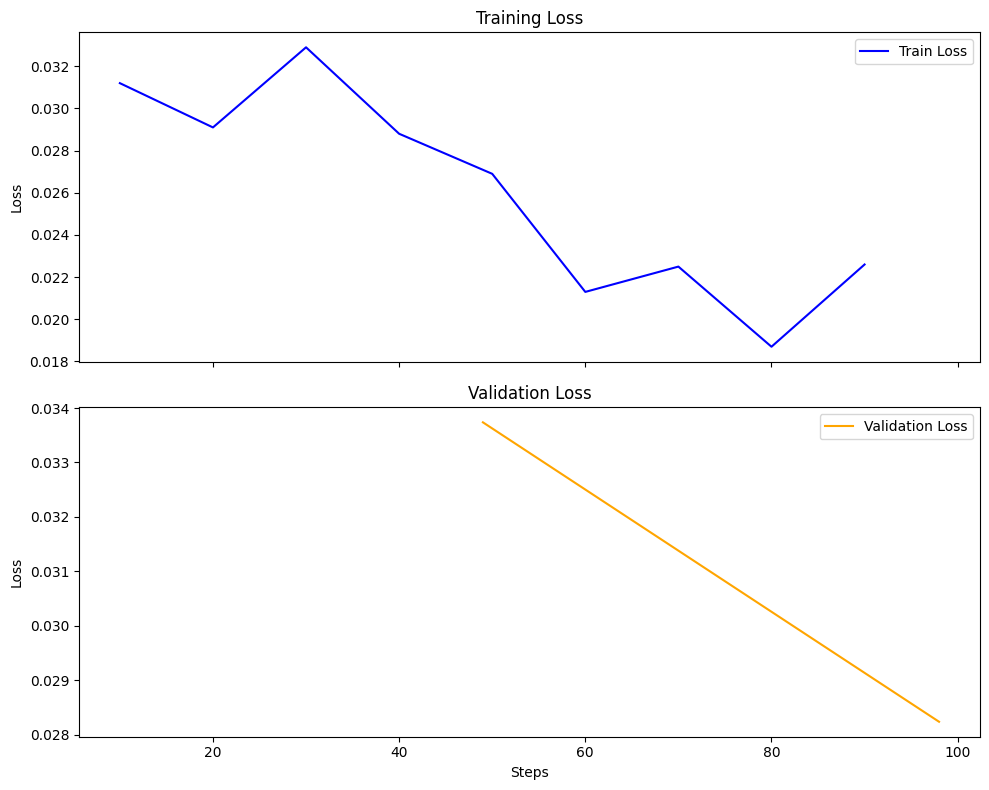

In [ ]:
# ===============================
# 12. Plot Loss Curves
# ===============================
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

axs[0].plot(train_steps, train_loss_history, label="Train Loss", color="blue")
axs[0].set_ylabel("Loss")
axs[0].set_title("Training Loss")
axs[0].legend()

axs[1].plot(eval_steps, eval_loss_history, label="Validation Loss", color="orange")
axs[1].set_xlabel("Steps")
axs[1].set_ylabel("Loss")
axs[1].set_title("Validation Loss")
axs[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
import json
from collections import defaultdict
from sentence_transformers import SentenceTransformer, util
from sklearn.metrics import (
    f1_score, accuracy_score, recall_score, precision_score
)
import torch
import numpy as np
import pandas as pd

# ============ Load model =============
model_path = "/content/drive/MyDrive/roberta-contrastive-model"
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SentenceTransformer(model_path, device=device)

# ============ Load data =============
with open("testing_data_1.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# ============ Group data by (genre, mode) =============
genre_mode_groups = defaultdict(list)
threshold = 0.5

for pair in data:
    g1 = pair[0]["genre"]
    g2 = pair[1]["genre"]
    label = int(pair[2])
    s1 = pair[0]["lyrics"]
    s2 = pair[1]["lyrics"]

    all_genres = set(g1 + g2)

    for genre in all_genres:
        in_both = genre in g1 and genre in g2
        mode = "per-genre" if in_both else "cross-genre"
        genre_mode_groups[(genre, mode)].append((s1, s2, label))

# ============ Evaluate each genre-mode group =============
rows = []

for (genre, mode), group in genre_mode_groups.items():
    sents1 = [x[0] for x in group]
    sents2 = [x[1] for x in group]
    labels = [x[2] for x in group]

    emb1 = model.encode(sents1, convert_to_tensor=True, device=device)
    emb2 = model.encode(sents2, convert_to_tensor=True, device=device)
    cos_sim = util.cos_sim(emb1, emb2).diagonal().cpu().numpy()
    preds = (cos_sim > threshold).astype(int)

    row = {
        "Genre": genre,
        "Mode": mode,
        "Accuracy": accuracy_score(labels, preds),
        "F1 Micro": f1_score(labels, preds, average="micro"),
        "F1 Weighted": f1_score(labels, preds, average="weighted"),
        "F1 Macro": f1_score(labels, preds, average="macro"),
        "Recall": recall_score(labels, preds),
        "Precision": precision_score(labels, preds),
    }
    rows.append(row)

# ============ Compute Overall Mode Stats ============
mode_summary = []

for mode in ["per-genre", "cross-genre"]:
    all_s1, all_s2, all_labels = [], [], []
    for (genre_key, mode_key), group in genre_mode_groups.items():
        if mode_key == mode:
            all_s1 += [x[0] for x in group]
            all_s2 += [x[1] for x in group]
            all_labels += [x[2] for x in group]

    if all_labels:
        emb1 = model.encode(all_s1, convert_to_tensor=True, device=device)
        emb2 = model.encode(all_s2, convert_to_tensor=True, device=device)
        cos_sim = util.cos_sim(emb1, emb2).diagonal().cpu().numpy()
        preds = (cos_sim > threshold).astype(int)

        row = {
            "Mode": mode,
            "Accuracy": accuracy_score(all_labels, preds),
            "F1 Micro": f1_score(all_labels, preds, average="micro"),
            "F1 Weighted": f1_score(all_labels, preds, average="weighted"),
            "F1 Macro": f1_score(all_labels, preds, average="macro"),
            "Recall": recall_score(all_labels, preds),
            "Precision": precision_score(all_labels, preds),
        }
        mode_summary.append(row)

# ============ Output Tables ============
df = pd.DataFrame(rows)
mode_df = pd.DataFrame(mode_summary)

pd.set_option("display.max_columns", None)

print("Metrics per Genre:")
print(df.sort_values(["Genre", "Mode"]).to_string(index=False))

print("\nMetrics per Mode:")
print(mode_df.sort_values("Mode").to_string(index=False))

Metrics per Genre:
Genre        Mode  Accuracy  F1 Micro  F1 Weighted  F1 Macro   Recall  Precision
民俗与传统 cross-genre  0.416667  0.416667     0.325926  0.377778 1.000000   0.363636
民俗与传统   per-genre  1.000000  1.000000     1.000000  1.000000 1.000000   1.000000
 爱与浪漫 cross-genre  0.413043  0.413043     0.291990  0.343205 0.971429   0.390805
 爱与浪漫   per-genre  0.650602  0.650602     0.524702  0.424851 1.000000   0.646341
生活与反思 cross-genre  0.537634  0.537634     0.397644  0.387877 1.000000   0.527473
生活与反思   per-genre  0.545455  0.545455     0.427083  0.427083 1.000000   0.523810
社会与现实 cross-genre  0.585366  0.585366     0.471056  0.417711 0.958333   0.589744
社会与现实   per-genre  0.272727  0.272727     0.116883  0.214286 1.000000   0.272727
风景与旅程 cross-genre  0.627451  0.627451     0.543558  0.521481 1.000000   0.595745
风景与旅程   per-genre  0.125000  0.125000     0.027778  0.111111 1.000000   0.125000

Metrics per Mode:
       Mode  Accuracy  F1 Micro  F1 Weighted  F1 Macro   Recall  Precis

In [ ]:
import json
from collections import defaultdict
from sentence_transformers import SentenceTransformer, util
from sklearn.metrics import (
    f1_score, accuracy_score, recall_score, precision_score
)
import torch
import numpy as np
import pandas as pd

# ============ Load model =============
model_path = "/content/drive/MyDrive/roberta-contrastive-model"
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SentenceTransformer(model_path, device=device)

# ============ Load data =============
with open("testing_data_2.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# ============ Group data by (genre, mode) =============
genre_mode_groups = defaultdict(list)
threshold = 0.5

for pair in data:
    g1 = pair[0]["genre"]
    g2 = pair[1]["genre"]
    label = int(pair[2])
    s1 = pair[0]["lyrics"]
    s2 = pair[1]["lyrics"]

    all_genres = set(g1 + g2)

    for genre in all_genres:
        in_both = genre in g1 and genre in g2
        mode = "per-genre" if in_both else "cross-genre"
        genre_mode_groups[(genre, mode)].append((s1, s2, label))

# ============ Evaluate each genre-mode group =============
rows = []

for (genre, mode), group in genre_mode_groups.items():
    sents1 = [x[0] for x in group]
    sents2 = [x[1] for x in group]
    labels = [x[2] for x in group]

    emb1 = model.encode(sents1, convert_to_tensor=True, device=device)
    emb2 = model.encode(sents2, convert_to_tensor=True, device=device)
    cos_sim = util.cos_sim(emb1, emb2).diagonal().cpu().numpy()
    preds = (cos_sim > threshold).astype(int)

    row = {
        "Genre": genre,
        "Mode": mode,
        "Accuracy": accuracy_score(labels, preds),
        "F1 Micro": f1_score(labels, preds, average="micro"),
        "F1 Weighted": f1_score(labels, preds, average="weighted"),
        "F1 Macro": f1_score(labels, preds, average="macro"),
        "Recall": recall_score(labels, preds),
        "Precision": precision_score(labels, preds),
    }
    rows.append(row)

# ============ Compute Overall Mode Stats ============
mode_summary = []

for mode in ["per-genre", "cross-genre"]:
    all_s1, all_s2, all_labels = [], [], []
    for (genre_key, mode_key), group in genre_mode_groups.items():
        if mode_key == mode:
            all_s1 += [x[0] for x in group]
            all_s2 += [x[1] for x in group]
            all_labels += [x[2] for x in group]

    if all_labels:
        emb1 = model.encode(all_s1, convert_to_tensor=True, device=device)
        emb2 = model.encode(all_s2, convert_to_tensor=True, device=device)
        cos_sim = util.cos_sim(emb1, emb2).diagonal().cpu().numpy()
        preds = (cos_sim > threshold).astype(int)

        row = {
            "Mode": mode,
            "Accuracy": accuracy_score(all_labels, preds),
            "F1 Micro": f1_score(all_labels, preds, average="micro"),
            "F1 Weighted": f1_score(all_labels, preds, average="weighted"),
            "F1 Macro": f1_score(all_labels, preds, average="macro"),
            "Recall": recall_score(all_labels, preds),
            "Precision": precision_score(all_labels, preds),
        }
        mode_summary.append(row)

# ============ Output Tables ============
df = pd.DataFrame(rows)
mode_df = pd.DataFrame(mode_summary)

pd.set_option("display.max_columns", None)

print("Metrics per Genre:")
print(df.sort_values(["Genre", "Mode"]).to_string(index=False))

print("\nMetrics per Mode:")
print(mode_df.sort_values("Mode").to_string(index=False))

Metrics per Genre:
Genre        Mode  Accuracy  F1 Micro  F1 Weighted  F1 Macro  Recall  Precision
民俗与传统 cross-genre  0.625000  0.625000     0.480769  0.384615     1.0   0.625000
民俗与传统   per-genre  1.000000  1.000000     1.000000  1.000000     1.0   1.000000
 爱与浪漫 cross-genre  0.375000  0.375000     0.204545  0.272727     1.0   0.375000
 爱与浪漫   per-genre  0.125000  0.125000     0.027778  0.111111     1.0   0.125000
生活与反思 cross-genre  0.363636  0.363636     0.193939  0.266667     1.0   0.363636
生活与反思   per-genre  0.461538  0.461538     0.291498  0.315789     1.0   0.461538
社会与现实 cross-genre  0.500000  0.500000     0.333333  0.333333     1.0   0.500000
社会与现实   per-genre  0.500000  0.500000     0.333333  0.333333     1.0   0.500000
风景与旅程 cross-genre  0.312500  0.312500     0.148810  0.238095     1.0   0.312500
风景与旅程   per-genre  0.500000  0.500000     0.333333  0.333333     1.0   0.500000

Metrics per Mode:
       Mode  Accuracy  F1 Micro  F1 Weighted  F1 Macro  Recall  Precision
cross-ge